## ТЗ <a name="TZ"></a>

Необходимо выявить определяющие успешность игры закономерности на основании данных о продажах, оценок, жанров, платформ




**Описание данных**

Представлены данные до 2016 года


Данные за 2016 год могут быть неполными.

## технические ф-ции

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


In [ ]:
def score_platform_corr (platforma):
    rab_table_for_score = df_discovery_table[df_discovery_table['platform'] == platforma]
    
    for stolbec in ['user_score','critic_score']:
        print('------------------')
        rab_table_for_score[rab_table_for_score[stolbec] != -1].plot.scatter(x=stolbec, y='total_sales');
        plt.show()
        print('коэффициент корреляции: {:.2f}'.format(rab_table_for_score[rab_table_for_score[stolbec] != -1]['total_sales'].corr(rab_table_for_score[rab_table_for_score[stolbec] != -1][stolbec])))

In [ ]:
def famous_popular_column (column):
  df_rab = df_discovery_table.copy()
  df_rab['na_sales'] = df_rab['na_sales']  / df_rab['na_sales_sum']
  df_rab['eu_sales'] = df_rab['eu_sales']  / df_rab['eu_sales_sum']
  df_rab['jp_sales'] = df_rab['jp_sales']  / df_rab['jp_sales_sum']

  for region in ['na_sales','eu_sales','jp_sales']:
    result = df_rab.groupby(column)[[region]].sum().sort_values(region, ascending = False).reset_index().head(5)
    result.columns = [['параметр','доля продаж']]
   
    print('{} доля:'.format(region))
    display(result)
    
    print()

  return 

## обзор данных <a name="data_review"></a>

In [ ]:

try:
  df = pd.read_csv('/datasets/games.csv')
except:
  df = pd.read_csv('https://.../games.csv')
    


In [ ]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
9353,Tak 2: The Staff of Dreams,XB,2004.0,Platform,0.10,0.03,0.00,0.00,73.0,tbd,E
11280,Beat Sketch!,PS3,2010.0,Misc,0.00,0.00,0.08,0.00,NaN,NaN,NaN
14655,NBA 2K13,PC,2012.0,Sports,0.00,0.02,0.00,0.00,90.0,6.8,E
5572,Kinetica,PS2,2001.0,Racing,0.16,0.12,0.00,0.04,77.0,8.3,T
1310,WCW vs the World,PS,1998.0,Fighting,1.17,0.20,0.04,0.05,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
df.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

ИТОГО: видим пропуски в некоторых столбцах. Надо разбираться с пропусками,типами данных и уникальными значениями

## подготовка данных <a name="data_preparing"></a>

### приведение наименования столбцов <a name="columns_naming"></a>

приведём названия столбцов к нижнему регистру

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### приведение типов данных <a name="types_preparing"></a>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
#df['user_score'].unique()

зменим типы данных:

year_of_release  -> int (в этом столбце есть пропуски- заменим их на технические значения "-1" для корректного преобразования и дальнейшего обсчёта). 

critic_score      -> int8  (т.к. максимальное значение "100" - то 8 бит будет достаточно. Очень много пропусков и заполнять искуственными  значениями (медиана, среднее, приравнивание) невозможно (т.к. оценка- субъективное значение) - поэтому заменим на техническое значение "-1" для удобства дальнейшей работы)

user_score      -> float64 (Очень много пропусков и заполнять искуственными  значениями (медиана, среднее, приравнивание) невозможно (т.к. оценка- субъективное значение) - поэтому заменим на техническое значение "-1" для удобства дальнейшей работы. Так же, есть 2424 шт значений "tbd" (to be determined) - странное решения для хранения на сервере данных- но по факту значения нет- соответственно, можем приравнять к значению "отсутствует", т.е. к "-1". Есть, так же, значения "0" - но удалять или переименовывать их не будем- такая оценка имеет место быть (очень плохой продукт))

In [ ]:
#year_of_release -> int
df['year_of_release'] = df['year_of_release'].fillna(-1)
df['year_of_release'] = df['year_of_release'].astype('int')
#df['year_of_release'].unique()

In [ ]:
#critic_score -> int8 
df['critic_score'] = df['critic_score'].fillna(-1)
df['critic_score'] = df['critic_score'].astype('int8')

In [ ]:
#user_score -> int8
df['user_score'] = df['user_score'].fillna(-1)
df['user_score'] = df['user_score'].replace('tbd' , -1)
df['user_score'] = df['user_score'].astype('float64')

In [ ]:
#df.info()

### обработка пропусков <a name="pass_preparing"></a>

In [ ]:
df[df['name'] != df['name']]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,-1,-1.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,-1,-1.0,NaN


необработанные в прошлых пунктах столбцы столбцы:

name - есть пропуски(2 шт), но с ними ничего не сделать -можно и удалить (внутри этих пустых строк все значения пустые (см строку выше)). НО (!), уникальных значений в столбце всего 70 %- соответственно либо есть дубликаты (одно значения для разных платформ), либо одна игра попала несколько раз с разными значениями- надо разбираться (в разделе дубликаты)

platform- вроде всё хорошо

genre- вроде всё хорошо

rating - есть пропуски, но с этим ничего не сдлеать (может игра не оценивалась или данные потеряны- в любом случае эта оценка полу-субъективна и востановить математически её сложно). Но, мы будем обрабатывать дубликаты в "name" + "platform"- может чего и востановим. 

Возможные значения согласно спецификации ESRB - 

«EC» («Early childhood») — «Для детей младшего возраста, 

«E» («Everyone») — «Для всех», 

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»,

 «T» («Teen») — «Подросткам», 
 
 «M» («Mature») — «Для взрослых», 
 
 «AO» («Adults Only 18+») — «Только для взрослых», 
 
 «RP» («Rating Pending») — «Рейтинг ожидается»

«K-A» («Kids to Adults»)— «Для детей и взрослых» - устаревшее

In [ ]:
#df['rating'].unique()

In [ ]:
# name - удалим строку с пустым значением
df = df[df['name'] == df['name']]
#df.info()

#### обработка дубликатов <a name="data_duplicated"></a>

Попробуем востановить данные через дубликаты по столбцам "name" + "platform"

In [ ]:
#df.info()

In [ ]:
df[df[['name', 'platform']].duplicated()]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83,8.5,T
4127,Sonic the Hedgehog,PS3,-1,Platform,0.0,0.48,0.00,0.00,43,4.1,E10+
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82,8.5,T
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83,5.5,E


возможных дубликатов или строчек для востановления данных немного- пройдёмся по ним вручную (не будем строить монструозные функции)

	Need for Speed: Most Wanted:

In [ ]:
df[(df['name'] == 'Need for Speed: Most Wanted') & ((df['platform'] == 'X360') | (df['platform'] == 'PC'))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83,8.5,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83,8.5,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82,8.5,T


ничего не востановить. Интересный факт- эта игра перевыпускалась (в 2005 и 2012 г.в.)

	работаем с Sonic the Hedgehog:

In [ ]:
df[(df['name'] == 'Sonic the Hedgehog') &  (df['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43,4.1,E10+
4127,Sonic the Hedgehog,PS3,-1,Platform,0.00,0.48,0.00,0.00,43,4.1,E10+


видим, что есть полный дубликат (строка 4127) с техническим знаением года релиза- удалим этот дубликат

In [ ]:
#df = df[(df['name'] != 'Sonic the Hedgehog') &  (df['platform'] != 'PS3') & (df['year_of_release'] != -1)]  эта строка почему-то не работает- попробуем подругому
df.loc[(df['name'] == 'Sonic the Hedgehog') &  (df['platform'] == 'PS3') & (df['year_of_release'] == -1) , 'year_of_release'] = -100
df = df[df['year_of_release'] != -100]


	работаем с Madden NFL 13:

In [ ]:
df[(df['name'] == 'Madden NFL 13') &  (df['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83,5.5,E


видим, что строка- 16230 - дубликат строки 604, но с другим значением продаж в США- примем за оригинал строку 604, а строку 16230 - удалим

In [ ]:
df.loc[(df['name'] == 'Madden NFL 13') &  (df['platform'] == 'PS3') & (df['na_sales'] == 0) , 'year_of_release'] = -100
df = df[df['year_of_release'] != -100]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


#### востановление данных в "rating" <a name="data_rating"></a>

востанавливать данные в столбце будем по следующей логике- у одной игры (одно название и год выпуска) рейтинг ESRB на разных платформах- один и тот же (при портировании на разные платформы- геймплей не меняется- соответственно не меняется и рейтиннг (теоритически)). То, что не востановится- оставим, ибо данная оценка математически не выводится

до востановления- было заполнено всего 9947 значений

In [ ]:
#df.tail()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16711 non-null  int64  
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     16711 non-null  int8   
 9   user_score       16711 non-null  float64
 10  rating           9947 non-null   object 
dtypes: float64(5), int64(1), int8(1), object(4)
memory usage: 1.4+ MB


создадим рабочку, где проставлен весь рейтинг

In [ ]:
df_rab_for_rating = df[df['rating'] == df['rating'] ][['name','year_of_release','rating']]


df_rab_for_rating.columns = ['name','year_of_release','rating_rab']
df_rab_for_rating['name_year'] = df_rab_for_rating['name'] + df_rab_for_rating['year_of_release'].astype('str')
df_rab_for_rating.drop_duplicates(subset=['name_year'], inplace= True)
df_rab_for_rating.reset_index(inplace = True)
df_rab_for_rating = df_rab_for_rating.drop('index', 1)

df_rab_for_rating



,name,year_of_release,rating_rab,name_year
0,Wii Sports,2006,E,Wii Sports2006
1,Mario Kart Wii,2008,E,Mario Kart Wii2008
2,Wii Sports Resort,2009,E,Wii Sports Resort2009
3,New Super Mario Bros.,2006,E,New Super Mario Bros.2006
4,Wii Play,2006,E,Wii Play2006
...,...,...,...,...
6492,Bust-A-Move 3000,2003,E,Bust-A-Move 30002003
6493,Mega Brain Boost,2008,E,Mega Brain Boost2008
6494,STORM: Frontline Nation,2011,E10+,STORM: Frontline Nation2011
6495,Plushees,2008,E,Plushees2008


добавим рабочий столбец

In [ ]:
df['name_year'] = df['name'] + df['year_of_release'].astype('str')

In [ ]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_year
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,Wii Sports2006
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN,Super Mario Bros.1985
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,Mario Kart Wii2008
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,Wii Sports Resort2009
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NaN,Pokemon Red/Pokemon Blue1996


In [ ]:
df = df.merge(df_rab_for_rating[['rating_rab', 'name_year' ]] , how = 'left' , on = 'name_year')

найдём индексы строк, в которых можем востановить "rating"

In [ ]:
d = df[(df['rating'] != df['rating']) & (df['rating_rab'] == df['rating_rab'])].index.to_list()
print(d)

[488, 523, 624, 692, 731, 795, 823, 1011, 1029, 1056, 1203, 1289, 1468, 1471, 1579, 1597, 1799, 1860, 1921, 1922, 2047, 2165, 2194, 2203, 2265, 2270, 2427, 2689, 2706, 2707, 2763, 2794, 2915, 2964, 3044, 3163, 3250, 3639, 3646, 3662, 3667, 3783, 3793, 3869, 3875, 3918, 4275, 4323, 4460, 4472, 4473, 4529, 4598, 4602, 4604, 4620, 4652, 4885, 5141, 5290, 5417, 5643, 5719, 5779, 5851, 5857, 5952, 6028, 6145, 6155, 6181, 6347, 6358, 6415, 6422, 6546, 6843, 6857, 6867, 6869, 7004, 7021, 7042, 7055, 7123, 7301, 7325, 7372, 7538, 7582, 8022, 8032, 8068, 8129, 8132, 8133, 8240, 8341, 8368, 8472, 8530, 8584, 8662, 8742, 8775, 8879, 8888, 8939, 9171, 9265, 9316, 9397, 9399, 9433, 9601, 9617, 9639, 9687, 9692, 9768, 9885, 9991, 10182, 10250, 10315, 10460, 10471, 10539, 10552, 10555, 10634, 10641, 10694, 10695, 10788, 10951, 11025, 11048, 11089, 11211, 11402, 11496, 11576, 11620, 11622, 11778, 11932, 11938, 11976, 12058, 12220, 12399, 12411, 12469, 12558, 12646, 12657, 12752, 12799, 12833, 12837, 1


восстанавливаем возможные значения

In [ ]:
for i in range(len(d)):
  #print(d[i]) 
  df.iloc[d[i], 10] = df.iloc[d[i], 12]

In [ ]:
df = df.drop('rating_rab', 1)
df = df.drop('name_year', 1)

после востановления - в "rating" стало заполнено 10162 значений

In [ ]:
print('востановили значений:', 10162 - 9947)

востановили значений: 215


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16710
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16711 non-null  int64  
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     16711 non-null  int8   
 9   user_score       16711 non-null  float64
 10  rating           10162 non-null  object 
dtypes: float64(5), int64(1), int8(1), object(4)
memory usage: 1.4+ MB


### получение дополнительных данных <a name="over_data"></a>

In [ ]:
#df.head()

добавим столбцы с суммарным na_sales , eu_sales , jp_sales , other_sales, total_sales

In [ ]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] +df['other_sales']
df['na_sales_sum']=df['na_sales'].sum()
df['eu_sales_sum']=df['eu_sales'].sum()
df['jp_sales_sum']=df['jp_sales'].sum()
df['other_sales_sum']=df['other_sales'].sum()



In [ ]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_sum,eu_sales_sum,jp_sales_sum,other_sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54,4400.57,2423.65,1297.34,791.24
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN,40.24,4400.57,2423.65,1297.34,791.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52,4400.57,2423.65,1297.34,791.24
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77,4400.57,2423.65,1297.34,791.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NaN,31.38,4400.57,2423.65,1297.34,791.24


## исследовательский анализ данных <a name="data_explorering"></a>

### кол-во игр в разные годы <a name="times_games_data"></a>

посчитаем исключив технический год "-1"

Text(0, 0.5, 'кол-во выпущенных игр')

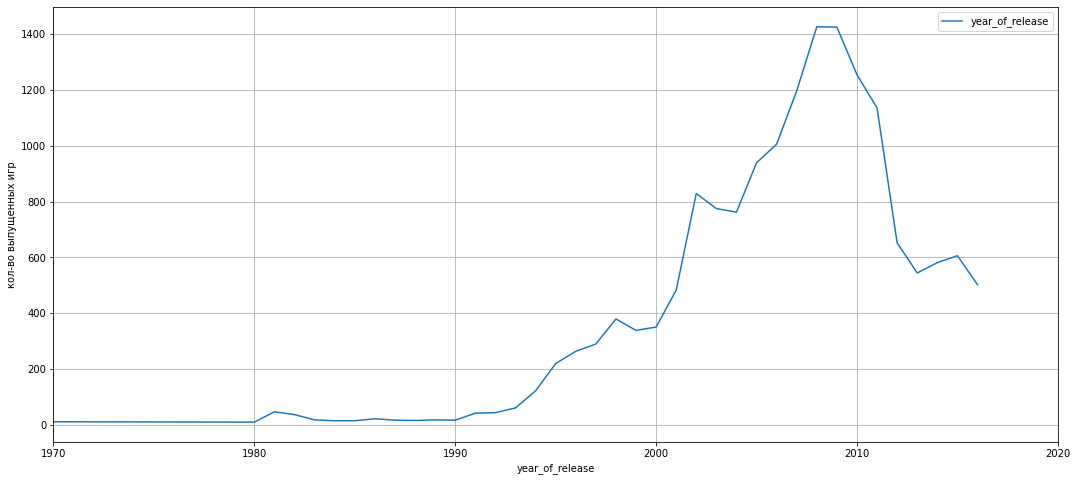

In [ ]:
df.groupby('year_of_release')[['year_of_release']].count().plot(xlim = (1970 , 2020) , grid = True  , legend = True, figsize = (18,8) ,
                                                               )
plt.ylabel('кол-во выпущенных игр')

мы видим, что производство игр начало расти в 90-ые годы и достигло своего пика в конце 00-ых. Использовать для анализа ранние периоды- нет смысла из-за их малого кол-ва (при условии, что система оценок игр не изменилась - в чём я сильно сомневаюсь).

In [ ]:
#df.groupby('year_of_release')[['year_of_release']].count()

### продажи по платформам <a name="sales_platform"></a>

определим суммарные продажи по каждой платформе

In [ ]:
#df.info() 
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [ ]:
sales_platform =df.groupby('platform')[['na_sales',	'eu_sales',	'jp_sales',	'other_sales']].sum().sort_values('na_sales', ascending = False).reset_index()

In [ ]:
sales_platform['total_sales'] = sales_platform['na_sales'] + sales_platform['eu_sales']+sales_platform['jp_sales']+sales_platform['other_sales']
sales_platform = sales_platform.sort_values('total_sales', ascending = False).reset_index(drop = True)
sales_platform.head(10) # десятка самых прибыльных платформ

,platform,na_sales,eu_sales,jp_sales,other_sales,total_sales
0,PS2,583.84,339.29,139.20,193.44,1255.77
1,X360,602.47,270.76,12.43,85.76,971.42
2,PS3,393.49,329.80,80.19,135.68,939.16
3,Wii,496.90,262.21,69.33,79.07,907.51
4,DS,382.40,188.89,175.57,59.26,806.12
5,PS,336.52,213.61,139.82,40.91,730.86
6,GBA,187.54,75.25,47.33,7.73,317.85
7,PS4,108.74,141.09,15.96,48.35,314.14
8,PSP,109.17,66.68,76.78,41.42,294.05
9,PC,94.53,142.44,0.17,22.38,259.52


покажем, что ТОП 10 - занимает львиную долю рынка:

In [ ]:
print('доля рынка "ТОП-10" платформ: {:.0%}'.format(sales_platform.head(10)['total_sales'].sum() / sales_platform['total_sales'].sum()))


доля рынка "ТОП-10" платформ: 76%


In [ ]:
#df.head(4)

выведем прибыли по годам у самых популярных платформ

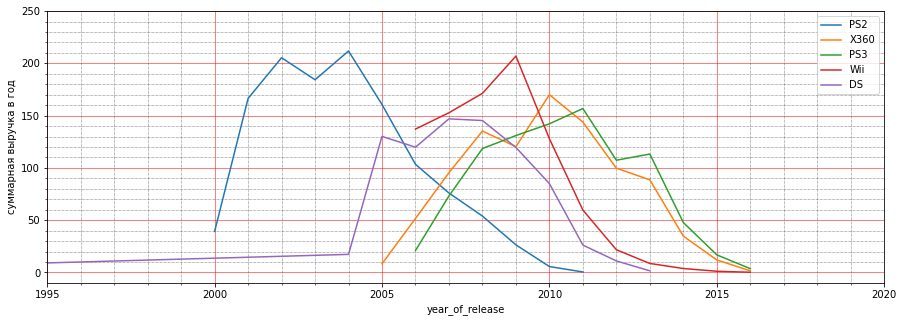

In [ ]:

count_platform = 5

fig, ax = plt.subplots()
for i in sales_platform.head(count_platform)['platform']:
  df[(df['platform'] == i) & (df['year_of_release'] != -1)].groupby('year_of_release')[['total_sales']].sum().plot(xlim = (1995 , 2020) ,ylim = (-10,250) , 
                                                                                          legend = True, figsize = (15,5) ,ax=ax, grid =True)                                                                                      
  ax.set_axisbelow(True)
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

#, ylabel = 'суммарная выручка в год' 
plt.ylabel('суммарная выручка в год')
ax.legend(sales_platform.head(count_platform)['platform']); 
plt.show()


In [ ]:
#df[(df['platform'] == 'DS') & (df['year_of_release'] != -1)].groupby('year_of_release')[['total_sales']].sum()

как мы видим из графика- ориентировочное время жизни (характериный срок службы) платформы - 8 лет

### получение исследовательской таблицы <a name="create_discovery_table"></a>

для получения исследовательской (рабочей) таблицы учтём тот факт, что характерный срок службы платформы - 8 лет. Соответсвенно отберём только те строки, годы релиза в которых >= 2009

построим столбчатую диаграмупродаж

In [ ]:
#df.head(3)

учтём средний срок платформы - 8 лет

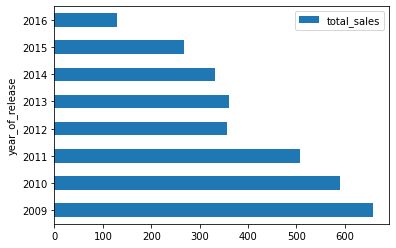

In [ ]:
df[df['year_of_release'] >= 2009].groupby('year_of_release')[['total_sales']].sum().reset_index().plot(kind = 'barh', x = 'year_of_release' , y = 'total_sales')

как мы видим из диаграммы продаж (год(сумма продаж)) стабилизиация после бурных продаж произошла с 2012г. Далее будем работать с годами >= 2012г. Данный факт можно объяснить сменой пользовательских предпочтений. 

В свою очередь- на смену предпочтений и уровень ожиданий потенциальных покупателей мог повлиять тот факт, что в 2012 году закончился характерный срок службы 2-ух крайне популярных платформ (DS and Wii) (это мы виим из графика в ячйке 45). Окончание срока платформ знамянуется появлением новых платформ (платформ следующего поколения), что в свою очередь повышает ожидание потенциальных покупателей.

In [ ]:
df_discovery_table = df[df['year_of_release'] >= 2012] # здесь подправил год с 2009 на 2012

In [ ]:
#df_discovery_table.head(4)

In [ ]:
df_discovery_table['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

In [ ]:
len(df_discovery_table['platform'].unique())

11

учитывая тот факт (получен в предыдущем пункте), что 10 платформ занимают 76% рынка - оставим в таблице только их (так, для интереса)

In [ ]:
df_discovery_table_golden_platform = df_discovery_table[df_discovery_table['platform'].isin(sales_platform.head(10)['platform']) ]

In [ ]:
df_discovery_table_golden_platform['platform'].unique()

array(['PS3', 'X360', 'PS4', 'DS', 'Wii', 'PC', 'PSP'], dtype=object)

### выбираем потенциально прибыльные платформы <a name="gold_platform"></a>

работать будем с df_discovery_table

критерий отбора потенциально прибыльных платформ- рост продаж или нахождение на пике к концу отчётного периода

посмотрим, что это за платформы:

In [ ]:
#df_discovery_table.head(3)

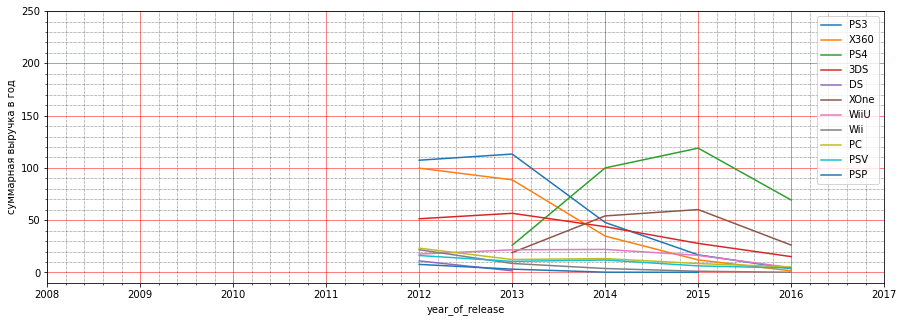

In [ ]:


fig, ax = plt.subplots()
for i in df_discovery_table['platform'].unique():
  df_discovery_table[df_discovery_table['platform'] == i].groupby('year_of_release')[['total_sales']].sum().plot(xlim = (2008 , 2017) ,ylim = (-10,250)  , 
                                                                                          legend = True, figsize = (15,5) ,ax=ax, grid =True)                                                                                      
  ax.set_axisbelow(True)
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

#, ylabel = 'суммарная выручка в год'
plt.ylabel('суммарная выручка в год')
ax.legend(df_discovery_table['platform'].unique()); 
plt.show()

на графикемы видим, что нам, более-менее, подходят только 2 платформы - **PS4 и XOne** - что сильно логично- самые новые платформы. А учитывая то, что данные за 2016 год могут быть неполными- сподвигает нас к этим платформам

### распределение кол-ва игр на платформах <a name="platform_count_game"></a>

построим "ящикс усами" для распределения игр по разным платформам (5 самых популярных платформ)


In [ ]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_sum,eu_sales_sum,jp_sales_sum,other_sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54,4400.57,2423.65,1297.34,791.24
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN,40.24,4400.57,2423.65,1297.34,791.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52,4400.57,2423.65,1297.34,791.24
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77,4400.57,2423.65,1297.34,791.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NaN,31.38,4400.57,2423.65,1297.34,791.24


In [ ]:
sales_platform.head(5)['platform']

0     PS2
1    X360
2     PS3
3     Wii
4      DS
Name: platform, dtype: object

In [ ]:
sales_platform =df_discovery_table.groupby('platform')[['na_sales',	'eu_sales',	'jp_sales',	'other_sales']].sum().sort_values('na_sales', ascending = False).reset_index()

In [ ]:
sales_platform.head(5)['platform']

0    X360
1     PS4
2     PS3
3    XOne
4     3DS
Name: platform, dtype: object

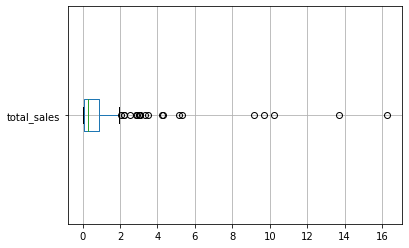

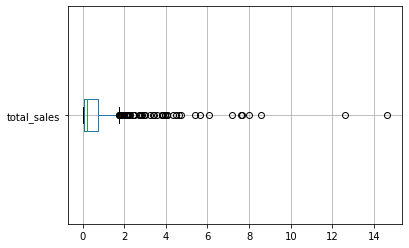

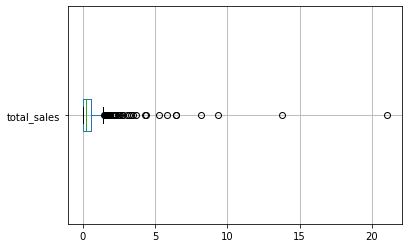

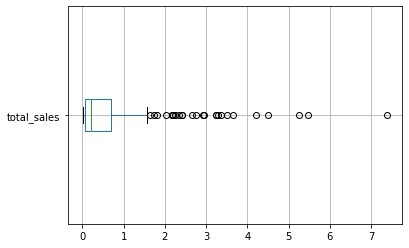

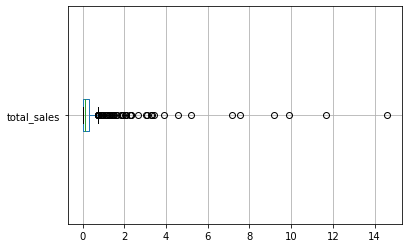

In [ ]:
rab_table = df_discovery_table[(df_discovery_table['platform'].isin(sales_platform.head(10)['platform']))]

for i in sales_platform.head(5)['platform']:
  boxpot = rab_table[rab_table['platform'] == i].boxplot(column = ['total_sales'], vert=False)
  plt.show()


In [ ]:


count_top_platform = 5

rab_table = df_discovery_table[(df_discovery_table['platform'].isin(sales_platform.head(count_top_platform)['platform']))]


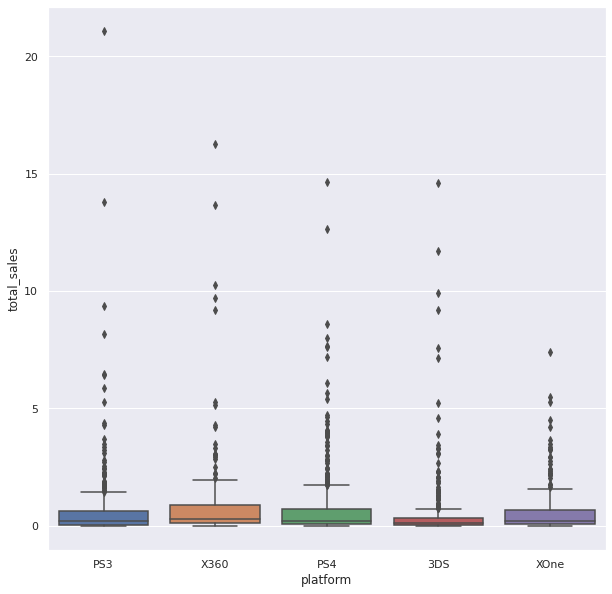

In [ ]:

sns.set(rc={'figure.figsize':(10, 10)})

sns.boxplot(data = rab_table, y = 'total_sales', x= 'platform', )

plt.show()

sns.set(rc={'figure.figsize':(5, 5)})

Мы видим, что выручка внутри платформ от игры к игре сильно разнится. Всё зависит от каждой конкретной игры. Ожидать, что для конкретной платформы новая игра принесёт столько-то - не приходится

### влияние отзывов пользователей и критиков <a name="score_discover"></a>

изберём самую популярную платформу - PS2. Работать в этом пункте будем с ней:

изберём самую популярную платформу - X360. Работать в этом пункте будем с ней:

In [ ]:
#rab_table_for_score = df[df['platform'] == 'PS2']
rab_table_for_score = df_discovery_table[df_discovery_table['platform'] == 'X360']



In [ ]:
#rab_table_for_score.head(3)

во время расчётов- будем исключать технические заполнения стобцов (-1)

приведём графики рассейния для функций зависимости суммарного дохода от оценки. Так же, покажем коэффициент корреляции этих величин:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


------------------


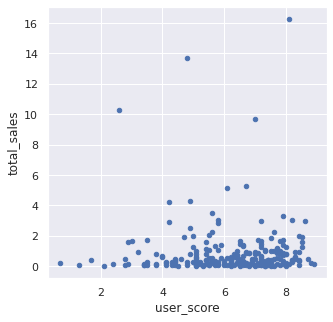

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


коэффициент корреляции: 0.01
------------------


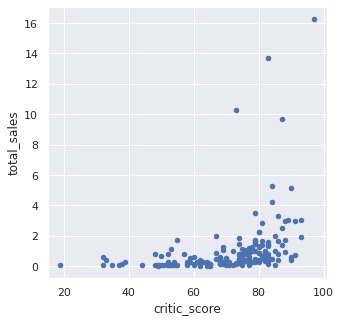

коэффициент корреляции: 0.36


In [ ]:
for stolbec in ['user_score','critic_score']:
  print('------------------')
  rab_table_for_score[rab_table_for_score[stolbec] != -1].plot.scatter(x=stolbec, y='total_sales');
  plt.show()
  print('коэффициент корреляции: {:.2f}'.format(rab_table_for_score[rab_table_for_score[stolbec] != -1]['total_sales'].corr(rab_table_for_score[rab_table_for_score[stolbec] != -1][stolbec])))

ИТОГО: взаимосвязь оценок игр и доходов, конечно, есть, но она очень слабая (коэффициенты корреляции- малы). Как и следовало ожидать- у самых доходных игр- самый высокий уровень оценок. Но, в общем случае- полагаться на уровни оценок не стоит. Судя по всему- продажи мало зависят от оценок критиков и пользователей, но сильно зависят от других факторов (как вариант- от рекламы)

Есть основания полагать, что данные выводы будут адекватно ложиться и на другие, менее доходные, платформы. (при условии, что рынок для всех конкурентов одинаков)

подциклим код:

In [ ]:
sales_platform.head(5)['platform']

0    X360
1     PS4
2     PS3
3    XOne
4     3DS
Name: platform, dtype: object

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


------------------


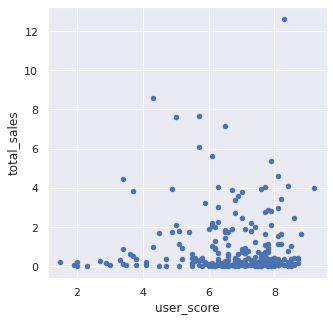

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


коэффициент корреляции: -0.03
------------------


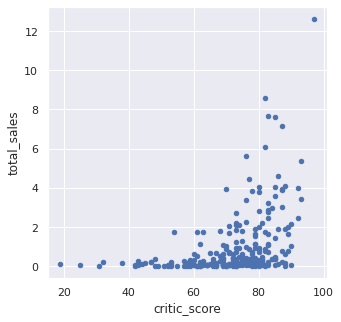

коэффициент корреляции: 0.41


In [ ]:
score_platform_corr('PS4')

результаты аналогичны

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


------------------


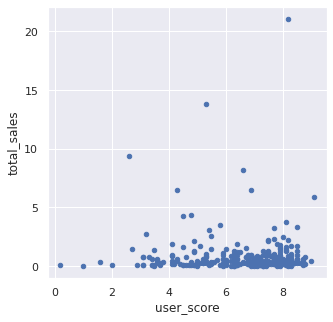

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


коэффициент корреляции: -0.01
------------------


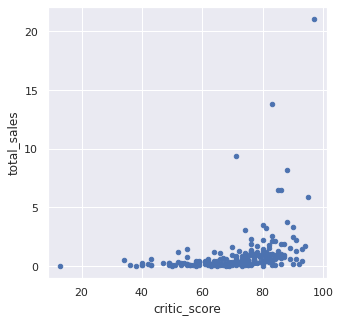

коэффициент корреляции: 0.33


In [ ]:
score_platform_corr('PS3')

результаты аналогичны

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


------------------


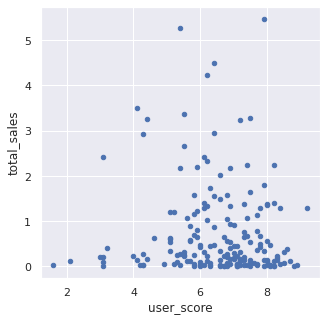

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


коэффициент корреляции: -0.07
------------------


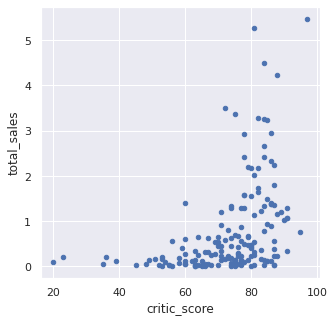

коэффициент корреляции: 0.42


In [ ]:
score_platform_corr('XOne')

результаты аналогичны

Вывод- выводы о слабой корреляции продаж и оценоок можно распростаранить на другие платформы

### распределение игр по жанрам <a name="genre_game"></a>


In [ ]:
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_sum,eu_sales_sum,jp_sales_sum,other_sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54,4400.57,2423.65,1297.34,791.24
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN,40.24,4400.57,2423.65,1297.34,791.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52,4400.57,2423.65,1297.34,791.24


найдём распределение кол-ва игр по жанрам:

In [ ]:
#count_genry = df.groupby('genre')[['genre']].count().rename(columns = {'genre': 'count'}).sort_values('count', ascending = False).reset_index()
count_genry = df_discovery_table.groupby('genre')[['genre']].count().rename(columns = {'genre': 'count'}).sort_values('count', ascending = False).reset_index()


#count_genry

мы видим, что больше всего игр выпускается в жанре Action and Sport

проверим- самые ли это прибыльные игры:


In [ ]:
#sales_genry = df.groupby('genre')[['total_sales']].sum().sort_values('total_sales', ascending = False).reset_index()
sales_genry = df_discovery_table.groupby('genre')[['total_sales']].sum().sort_values('total_sales', ascending = False).reset_index()


#sales_genry

сведём в одну таблицу

In [ ]:
svod_genre = count_genry.merge(sales_genry, how = 'left', on = 'genre').sort_values('total_sales', ascending = False ).reset_index()
svod_genre

,index,genre,count,total_sales
0,0,Action,1031,441.12
1,4,Shooter,235,304.73
2,1,Role-Playing,370,192.80
3,3,Sports,267,181.06
4,5,Misc,192,85.04
5,8,Platform,85,61.00
6,6,Racing,115,53.50
7,7,Fighting,109,44.49
8,9,Simulation,80,35.12
9,2,Adventure,302,29.43


как видно из таблицы- самые прибыльные жанры Action Sports и Shooter, но на 3-ем месте поиздаваемости игр - Misc.

В общем, прибыль сильно зависит от жанра. Люди любят определённые жанры- за них и голосуют рублём ...

In [ ]:
count_genry2 = df_discovery_table.groupby('genre')[['genre']].count().rename(columns = {'genre': 'count'}).sort_values('count', ascending = False).reset_index()
sales_genry2 = df_discovery_table.groupby('genre')[['total_sales']].median().sort_values('total_sales', ascending = False).reset_index()

svod_genre2 = count_genry2.merge(sales_genry2, how = 'left', on = 'genre').sort_values('total_sales', ascending = False ).reset_index()
svod_genre2


,index,genre,count,total_sales
0,4,Shooter,235,0.440
1,3,Sports,267,0.240
2,8,Platform,85,0.210
3,1,Role-Playing,370,0.140
4,6,Racing,115,0.140
5,7,Fighting,109,0.130
6,0,Action,1031,0.120
7,5,Misc,192,0.120
8,9,Simulation,80,0.120
9,10,Strategy,71,0.080


если смотреть по медианным продажам- то тройка лидеров немного меняется -Shooter  Sports Platform

Но попробуем сделать ещё один расчёт исходя из следующей логики-  если перед нами стоит частная задача: выбрать игру исходя только из её жанра (как частный параметр общего большого расчёта)- то можем посчитать среднюю прибыль с игры. В данном случае нам будет важно учесть в расчёте и хиты, ведь если в жанре очень много хитов, то и вероятность попасть на хит при выборе одной игры, больше, что математически увеличивает потенциальную прибыль

In [ ]:
#svod_genre.head(5)

In [ ]:
svod_genre['удельная_стоимость'] = svod_genre['total_sales'] / svod_genre['count']
svod_genre = svod_genre.sort_values('удельная_стоимость', ascending = False).reset_index()
svod_genre.head(5)

,level_0,index,genre,count,total_sales,удельная_стоимость
0,1,4,Shooter,235,304.73,1.296723
1,5,8,Platform,85,61.00,0.717647
2,3,3,Sports,267,181.06,0.678127
3,2,1,Role-Playing,370,192.80,0.521081
4,6,6,Racing,115,53.50,0.465217


при данном расчёте тройка лидеров осталась та же. Но видим интересную картину- удельная стоимость игры исходя только из жанкра- у Шутеров на голову выше всех остальных

## портреты пользователей <a name="user_dorian_grey"></a>

---
Определите для пользователя каждого региона (NA, EU, JP) (top-5)

___




создадим ф-цию для уменьшения кол-ва кода:

работаем с df:

работаем с df_discovery_table:

In [ ]:
df_discovery_table.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_sum,eu_sales_sum,jp_sales_sum,other_sales_sum
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05,4400.57,2423.65,1297.34,791.24
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27,4400.57,2423.65,1297.34,791.24
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,NaN,14.63,4400.57,2423.65,1297.34,791.24


In [ ]:
df_discovery_table= df_discovery_table.reset_index()
df_discovery_table['total_sales'] = df_discovery_table[['na_sales','eu_sales','jp_sales','other_sales']].sum()
df_discovery_table['na_sales_sum']=df_discovery_table['na_sales'].sum()
df_discovery_table['eu_sales_sum']=df_discovery_table['eu_sales'].sum()
df_discovery_table['jp_sales_sum']=df_discovery_table['jp_sales'].sum()
df_discovery_table['other_sales_sum']=df_discovery_table['other_sales'].sum()

df_discovery_table.head(3)

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_sum,eu_sales_sum,jp_sales_sum,other_sales_sum
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,NaN,590.97,506.81,192.58,156.16
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,NaN,590.97,506.81,192.58,156.16
2,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,NaN,NaN,590.97,506.81,192.58,156.16


### cамые популярные платформы <a name="platform_popular"></a>


посмотрим распределегие по регионам и платформам (топ-5):

In [ ]:
famous_popular_column('platform')

na_sales доля:


,параметр,доля продаж
0,X360,0.236983
1,PS4,0.184003
2,PS3,0.174933
3,XOne,0.157571
4,3DS,0.093592



eu_sales доля:


,параметр,доля продаж
0,PS4,0.278388
1,PS3,0.210829
2,X360,0.147037
3,XOne,0.101794
4,3DS,0.084134



jp_sales доля:


,параметр,доля продаж
0,3DS,0.455862
1,PS3,0.183249
2,PSV,0.109253
3,PS4,0.082875
4,WiiU,0.067556


как мы видим-- платформы различаются. Есть пересечение- PS3, PS4, 3DS . Европа сильно похожа по своим предпочтения на США, а Япония- отдельная планета. 

Так же, в Японии топ-3 занимает большую часть рынка


### cамые популярные жанры  <a name="genre_popular"></a>




In [ ]:
famous_popular_column('genre')

na_sales доля:


,параметр,доля продаж
0,Action,0.300929
1,Shooter,0.244970
2,Sports,0.137960
3,Role-Playing,0.108297
4,Misc,0.064623



eu_sales доля:


,параметр,доля продаж
0,Action,0.314398
1,Shooter,0.223891
2,Sports,0.136304
3,Role-Playing,0.095756
4,Racing,0.053847



jp_sales доля:


,параметр,доля продаж
0,Role-Playing,0.339807
1,Action,0.274172
2,Misc,0.066777
3,Simulation,0.054055
4,Fighting,0.049019


Опять: старый и новый свет очень похоже, а Япония- другой мир

### влияние рейтинга ESRB  <a name="ESRB_zanoza"></a>




In [ ]:
#df.head(3)

In [ ]:
df_discovery_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            2885 non-null   int64  
 1   name             2885 non-null   object 
 2   platform         2885 non-null   object 
 3   year_of_release  2885 non-null   int64  
 4   genre            2885 non-null   object 
 5   na_sales         2885 non-null   float64
 6   eu_sales         2885 non-null   float64
 7   jp_sales         2885 non-null   float64
 8   other_sales      2885 non-null   float64
 9   critic_score     2885 non-null   int8   
 10  user_score       2885 non-null   float64
 11  rating           1677 non-null   object 
 12  total_sales      0 non-null      float64
 13  na_sales_sum     2885 non-null   float64
 14  eu_sales_sum     2885 non-null   float64
 15  jp_sales_sum     2885 non-null   float64
 16  other_sales_sum  2885 non-null   float64
dtypes: float64(10)

заменим пропуски на техническое значение "ZZZ"

In [ ]:
df_discovery_table['rating'] = df_discovery_table['rating'].fillna('ZZZ')

напомнимобозначение рейтингов:

«EC» («Early childhood») — «Для детей младшего возраста,

«E» («Everyone») — «Для всех»,

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»,

«T» («Teen») — «Подросткам»,

«M» («Mature») — «Для взрослых»,

«AO» («Adults Only 18+») — «Только для взрослых»,

«RP» («Rating Pending») — «Рейтинг ожидается»

«K-A» («Kids to Adults»)— «Для детей и взрослых» - устаревшее

In [ ]:
df_ESRB = df_discovery_table.groupby('rating')[['na_sales','eu_sales','jp_sales']].sum()


In [ ]:
df_ESRB = df_ESRB.sort_values('na_sales'	, ascending = False).reset_index()

заменим суммы на %

In [ ]:
df_ESRB['na_sales'] =100* df_ESRB['na_sales'] / df_ESRB['na_sales'].sum()
df_ESRB['eu_sales'] =100* df_ESRB['eu_sales'] / df_ESRB['eu_sales'].sum()
df_ESRB['jp_sales'] =100* df_ESRB['jp_sales'] / df_ESRB['jp_sales'].sum()
df_ESRB

,rating,na_sales,eu_sales,jp_sales
0,M,39.685602,38.896233,11.086302
1,E,19.489991,22.446282,14.783467
2,ZZZ,16.261401,16.386812,55.670371
3,E10+,13.083574,11.353367,4.304705
4,T,11.479432,10.917306,14.155156




Опять же ситуация для старо-нового света примерно похожа. Лидером являются игры с рейтингом М (для взрослых). Топ-2 ("М" + "Е") большую часть рынка.

у Японии опять всё по-своему: лидером (подавляющим всех остальных) являются непромаркированные игры (судя по всему- это игры для внутреннего рынка ЧЯпонии- поэтому они не маркируются организацией, которая создана для маркировки игр для рынка США)

##  проверка гипотез <a name="gipotiz_day"></a>

In [ ]:
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_sum,eu_sales_sum,jp_sales_sum,other_sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54,4400.57,2423.65,1297.34,791.24
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN,40.24,4400.57,2423.65,1297.34,791.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52,4400.57,2423.65,1297.34,791.24


### cредние пользовательские рейтинги платформ Xbox One и PC одинаковые  <a name="gipo_1"></a>



In [ ]:
#df['platform'].unique()

посмотрим на распределения рейтингов этих платформ:

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

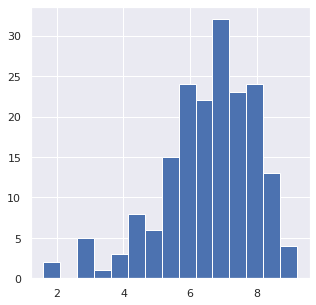

In [ ]:
df[(df['platform'] == 'XOne') & (df['user_score'] != -1)]['user_score'].hist(bins = 15)
df[(df['platform'] == 'XOne') & (df['user_score'] != -1)]['user_score'].describe()

count    770.000000
mean       7.062468
std        1.529963
min        1.400000
25%        6.200000
50%        7.500000
75%        8.200000
max        9.300000
Name: user_score, dtype: float64

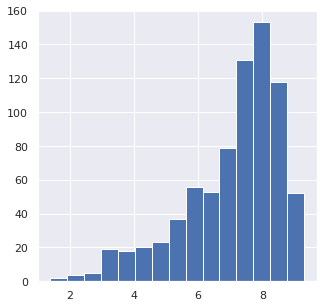

In [ ]:
df[(df['platform'] == 'PC') & (df['user_score'] != -1)]['user_score'].hist(bins = 15)
df[(df['platform'] == 'PC') & (df['user_score'] != -1)]['user_score'].describe()

как мы видим- данные распределения неплохо описываются средним значением. Среднее значение близко к медиане. Смело можем применять Т-Тест для сравнения средних 2-ух выборок

примем за нулевую гипотезу- средние рейтниги для 2-ух платформ одинаковы

In [ ]:
alpha = 0.05

In [ ]:
result = st.ttest_ind(df_discovery_table[(df_discovery_table['platform'] == 'XOne') & (df_discovery_table['user_score'] != -1)]['user_score'] ,
                      df_discovery_table[(df_discovery_table['platform'] == 'PC') & (df_discovery_table['user_score'] != -1)]['user_score'] ,
                      equal_var= False)
print('р-значение:', result.pvalue)

if result.pvalue < alpha:
  print('нулевая гипотеза не подтвердилась')
else:
  print('принимаем нулевую гипотезу при уровне доверия Р=0,95')

р-значение: 0.5489537965134912
принимаем нулевую гипотезу при уровне доверия Р=0,95


Предположение, что пользовательские рейтинги 2-ух платформ одинаковые- не подтвердились. Судя по цифрам- игры для ПК людям нравятся больше (Ну, или, пользователи ПК менее привередливы - что больше похоже на правду- ведь ПК- это ещё и инструмент, а консоль- изначально смотрит в сторону развлечений)

### cредние пользовательские рейтинги жанров Action и Sports  разные  <a name="gipo_2"></a>



In [ ]:
#df.head(3)

посмотрим на распределения рейтингов этих жанров:

count    1830.000000
mean        7.054044
std         1.425394
min         0.300000
25%         6.300000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

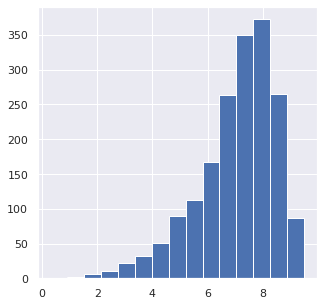

In [ ]:
df[(df['genre'] == 'Action') & (df['user_score'] != -1)]['user_score'].hist(bins = 15)
df[(df['genre'] == 'Action') & (df['user_score'] != -1)]['user_score'].describe()

count    1102.000000
mean        6.962523
std         1.611500
min         0.200000
25%         6.100000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

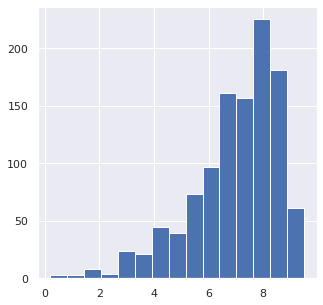

In [ ]:
df[(df['genre'] == 'Sports') & (df['user_score'] != -1)]['user_score'].hist(bins = 15)
df[(df['genre'] == 'Sports') & (df['user_score'] != -1)]['user_score'].describe()

как мы видим- данные распределения неплохо описываются средним значением. Среднее значение близко к медиане. Смело можем применять Т-Тест для сравнения средних 2-ух выборок

примем за нулевую гипотезу- средние рейтниги для 2-ух жанров одинаковы

In [ ]:
alpha = 0.05

In [ ]:
result = st.ttest_ind(df[(df['genre'] == 'Action') & (df['user_score'] != -1)]['user_score'] ,
                      df[(df['genre'] == 'Sports') & (df['user_score'] != -1)]['user_score'] ,
                      equal_var= False)
print('р-значение:', result.pvalue)

if result.pvalue < alpha:
  print('нулевая гипотеза не подтвердилась')
else:
  print('принимаем нулевую гипотезу при уровне доверия Р=0,95')

р-значение: 0.12024530426190537
принимаем нулевую гипотезу при уровне доверия Р=0,95


Предположение, что пользовательские рейтинги 2-ух жанров одинаковые-подтвердилось (при уровне доверия Р=0,95). Можем предположить, людям нравятся активности (хоть и в видео-играх). 

##  вывод <a name="the_end"></a>

В ходе рассмотрения данных выявлен ряд закономерностей, которые, могут повлиять на успешность  продаж игр в 2017г:

*   наиболее перспективные платформы- PS4 and X-Box_One - данные платформы пока мало популярны, но они в начале своего потребительского цикла (вероятно, это важно для среднесрочного планирования)
*   оценки критиков и пользователей- влияют на продаваемость мало


Но при работе на разных рынках появляются особенности каждого рынка:

**Рынок Европы и США**:
эти рынки очень похожи- поэтому дадим единое описание. Единственное значимое отличие- рынок США выше (но это логично)

*   самые популярные платформы-  PS3, PS4, X360
*   самые популярные жанры-  Action, Shooter, Sports 
*   самые популярные рейтинги ESRB-  львиную долю монетизации занимает рейтинг "М", на втором месте "Е". Топ-2 занимает большую часть рынка


**Рынок Японии**:
рынок Японии сильно отличается от рынкастарого света.

*   самые популярные платформы-  PS3, 3DS. 3DS- доминирует на рынке. Для среднесрочного планирования рекомендуем искать новое поколение платформы 3DS- ожидаемый лидер Японского рынка
*   самые популярные жанры- Role-Playing, Action  
*   самые популярные рейтинги ESRB-  львиную долю монетизации занимает рейтинг без маркировки (вероятно- продукция для внутреннего рынка Японии, не поставляющаяся на другие рынки)

